# Natural diversity

Compare mutational data against existing PB1 diversity, as well as generate sequence logos for regions of interst for the sake of looking how different bases impact fitness.

PB1 sequences from NCBI flu database (https://www.ncbi.nlm.nih.gov/genomes/FLU/Database/nph-select.cgi?go=database)
    Jul 25 2024

Parameters were to exclude lab strains, exclude vaccine strains, only full-length, only sequences of 2341 in length.

CD-HIT-est was then used to cluster anything with 99% identity to attempt to reduce over-represented sequences. 

Removed any sequences with ambiguous characters.

Manually curated to remove clear indels, as sequences should align with no effort.

This results in 1939 high-quality PB1 sequences. We did not restrict based on host, which could produce some disagreement with data.

In [11]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
scripts = 'Scripts'
sys.path.append(scripts)
import mutCalling
import scipy
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import dmslogo
from statsmodels.stats import multitest
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})

In [12]:
import importlib
importlib.reload(mutCalling)
PB1align = 'Database/reducedFluPB1.fa'
if not os.path.isdir('Results'):
    os.mkdir('Results')
if not os.path.isdir('Results/naturalAnalysis'):
    os.mkdir('Results/naturalAnalysis')
mutCalling.fastaReport(inFasta=PB1align, outfile='Results/naturalAnalysis/PB1natural.tsv')

In [13]:
def reverseComplementDataframe(inframe):
    maxpos = inframe['position'].max()
    modFrame = inframe.copy()
    modFrame['realpos'] = abs(maxpos - modFrame['position']) + 1
    outframe = pd.DataFrame()
    outframe['position'] = modFrame['realpos']
    outframe['A'] = modFrame['T']
    outframe['T'] = modFrame['A']
    outframe['C'] = modFrame['G']
    outframe['G'] = modFrame['C']
    return outframe

data = reverseComplementDataframe(pd.read_csv('Results/naturalAnalysis/PB1natural.tsv', sep='\t'))

data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0
data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

Call as binary. Where to set threshold? Lets do a rarefaction analysis.

In [14]:
currFrac = 0.0001
step = 0.0001
graph = []
totalsites = len(data)
while currFrac <= 0.75:
    totals = len(data.loc[data.minorityFreq>= currFrac])/totalsites
    graph += [pd.DataFrame({'variable_cutoff':[currFrac], 'fraction of sites':[totals]})]
    currFrac += step
graph = pd.concat(graph)
    

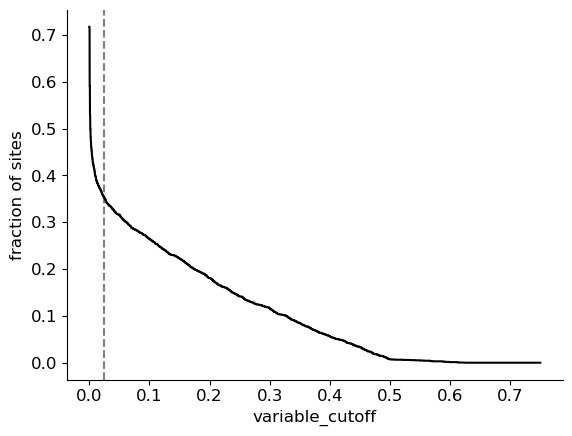

In [15]:
sns.lineplot(data=graph, x='variable_cutoff', y='fraction of sites', color='k')
plt.axvline(0.025, ls = '--', alpha =0.5, color = 'k')
sns.despine()
plt.savefig('Figures/variantCutoff.pdf', format='pdf', bbox_inches = "tight")


In [16]:
data['category'] = 'CDS'
data.loc[data['position'] <= 13, 'category'] = 'U13'
data.loc[data['position'] >= (data['position'].max() - 12), 'category'] = 'U12'
data.loc[(data['position'] <= 125) & (data['position'] >= 75), 'category'] = 'del1'
data.loc[(data['position'] <= 2192) & (data['position'] >= 2116), 'category'] = 'del2'
data.loc[(data['position'] <= 43) & (data['position'] >= 14), 'category'] = '5UTR'
data.loc[(data['position'] <= 2329) & (data['position'] >= 2318), 'category'] = '3UTR'
data['variable'] = data.minorityFreq > 0.025

In [17]:
graph = data.loc[data.category.isin(['del1','CDS']),]
graph['del1'] = graph.category == 'del1'

/tmp/ipykernel_771890/2539276962.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['del1'] = graph.category == 'del1'


The null hypothesis is rejected at a pvalue of 0.004914743692407157


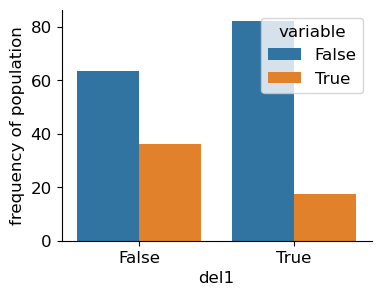

In [18]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

contingency = pd.crosstab(graph.del1, graph.variable)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(graph.del1, graph.variable, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'del1', y='value', hue='variable', data=frequency, ax = ax)
sns.despine()
ax.set_ylabel('frequency of population')

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/variationNatDivdel1vsCDS.pdf', format='pdf', bbox_inches = "tight")

In [19]:
graph = data.loc[data.category.isin(['del1','del2']),]
graph['del1'] = graph.category == 'del1'

/tmp/ipykernel_771890/4277197187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['del1'] = graph.category == 'del1'


The null hypothesis is rejected at a pvalue of 0.011277504702618298


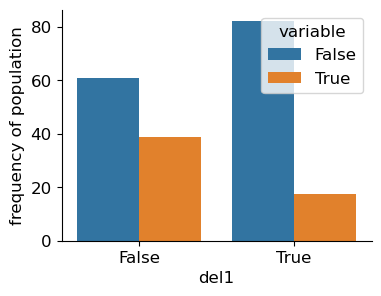

In [20]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

contingency = pd.crosstab(graph.del1, graph.variable)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(graph.del1, graph.variable, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'del1', y='value', hue='variable', data=frequency, ax = ax)
sns.despine()
ax.set_ylabel('frequency of population')

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/variationNatDivdel1vsdel2.pdf', format='pdf', bbox_inches = "tight")

In [21]:
dataFolder = 'Results/SNPcounts'

#adjust coordinates for adapters
posAdjustAmplicon = 14
posAdjustRACE = 30
PB1delLength = 562

posAdjustRACEplas = 56


In [22]:
data = []
for file in glob.glob('Results/SNPcounts/*.tsv'):
    baseName = os.path.basename(file)
    if baseName.split('_')[0] == 'RACE':
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0].split('_')[1]
        currData['replicate'] = baseName.split('-')[1][0]
        if baseName.split('-')[0].split('_')[1] != 'plas':
            currData['position'] = currData['position']-posAdjustRACE
        else:
            currData['position'] = currData['position']-posAdjustRACEplas
        currData['sequencing'] = 'RACE'
        #only use to infer to first and last 20 nt
        currData = currData[(currData['position'] <= 20) | (currData['position'] > PB1delLength - 20)]
        data += [currData]

    else:
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0]
        currData['replicate'] = baseName.split('-')[1][0]
        currData['position'] = currData['position']-posAdjustAmplicon
        currData['sequencing'] = 'amplicon'
        #exclude first and last 20 nt
        currData = currData[(currData['position'] > 20) & (currData['position'] <=PB1delLength - 20)]
        data += [currData]
data = pd.concat(data)
data = data.loc[(data.position > 0) & (data.position <= PB1delLength)]

In [23]:
data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0
plasmid = data.loc[(data.category == 'plas'),]
data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

In [24]:
allPoints = data.pivot_table(index=['position', 'replicate'], columns='category', values='minorityFreq').reset_index()
allPoints['difference'] = np.log2(allPoints.withNEP/allPoints.noNEP)
allPoints['pval_difference'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].difference, popmean=0)[1], axis =1 )

allPoints['mg'] = np.log2(allPoints.noNEP/allPoints.plas)
allPoints['pval_mg'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].mg, popmean=0)[1], axis =1 )

allPoints['NS2'] = np.log2(allPoints.withNEP/allPoints.plas)
allPoints['pval_NS2'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].NS2, popmean=0)[1], axis =1 )


PB1length = 2341
allPoints['context'] = 'CDS'
allPoints.loc[allPoints.position <= 24, 'context'] = '3\' UTR'
allPoints.loc[allPoints.position <= 12, 'context'] = 'U12'
allPoints.loc[allPoints.position >= 519, 'context'] = '5\' UTR'
allPoints.loc[(allPoints.position >= 542) & (allPoints.position <= 547), 'context'] = 'polyA'

allPoints.loc[allPoints.position >= 550, 'context'] = 'U13'
#fix position in positive then invert
junctionLastBase = 385
otherSideExclude = 2164

allPoints['FullLengthPos'] = allPoints.position
allPoints.loc[allPoints.position > 385, 'FullLengthPos'] = allPoints.loc[allPoints.position > 385].FullLengthPos + otherSideExclude -junctionLastBase 
#now invert
allPoints['FullLengthPos'] = PB1length - allPoints.FullLengthPos + 1


#combine measurements for appropriate qval and some graphing
freqCompare = allPoints[['FullLengthPos',
 'NS2',
 'context',
 'difference',
 'mg',
 'position',
 'pval_NS2',
 'pval_difference',
 'pval_mg',]].groupby(['FullLengthPos','context']).mean().reset_index()


freqCompare['qval_difference'] =  multitest.multipletests(freqCompare.pval_difference, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant_difference'] = (freqCompare.qval_difference < 0.1) & (abs(freqCompare.difference) >= 1)

freqCompare['qval_mg'] =  multitest.multipletests(freqCompare.pval_mg, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant_mg'] = freqCompare.qval_mg < 0.1

freqCompare['qval_NS2'] =  multitest.multipletests(freqCompare.pval_NS2, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant_NS2'] = freqCompare.qval_NS2 < 0.1

In [25]:
NS2responsive = freqCompare[freqCompare.significant_difference].FullLengthPos

In [26]:
freqCompare[freqCompare.significant_difference][['context','FullLengthPos','difference','pval_difference','qval_difference']].to_csv('Figures/NS2_responsive_sites.tsv', index=False, sep='\t')

In [27]:
def reverseComplementDataframe(inframe):
    maxpos = inframe['position'].max()
    modFrame = inframe.copy()
    modFrame['realpos'] = abs(maxpos - modFrame['position']) + 1
    outframe = pd.DataFrame()
    outframe['position'] = modFrame['realpos']
    outframe['A'] = modFrame['T']
    outframe['T'] = modFrame['A']
    outframe['C'] = modFrame['G']
    outframe['G'] = modFrame['C']
    return outframe

data = reverseComplementDataframe(pd.read_csv('Results/naturalAnalysis/PB1natural.tsv', sep='\t'))

data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0
data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)

In [28]:
data['category'] = data['position'].isin(NS2responsive)
data['variable'] = data.minorityFreq > 0.025

The null hypothesis is rejected at a pvalue of 1.4341078095462772e-05


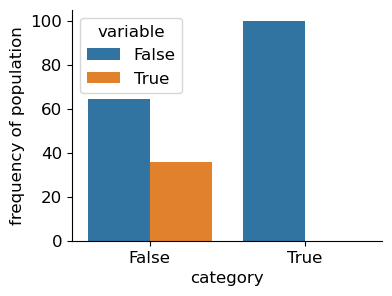

In [29]:
fig,ax = plt.subplots(1,1, figsize=(4,3))

contingency = pd.crosstab(data.category, data.variable)
ratio, pval = scipy.stats.fisher_exact(contingency)
frequency = pd.crosstab(data.category, data.variable, normalize='index').stack().reset_index().rename(columns={0:'value'})
frequency['value'] = frequency.value * 100
sns.barplot(x= 'category', y='value', hue='variable', data=frequency, ax = ax)
sns.despine()
ax.set_ylabel('frequency of population')

if(pval < 0.05):
    print('The null hypothesis is rejected at a pvalue of {0}'.format(str(pval)))
else:
    print('the null hypothesis fails to be rejected at a pvalue of '.format(str(pval)))
sns.despine()
a = plt.ylabel('frequency of population')
plt.savefig('Figures/variationNS2respvsall.pdf', format='pdf', bbox_inches = "tight")

Logo of inter-segmental?

In [61]:
import importlib
importlib.reload(mutCalling)

vRNA30nt = 'Database/vRNAprom.fa'
if not os.path.isdir('Results'):
    os.mkdir('Results')
if not os.path.isdir('Results/naturalAnalysis'):
    os.mkdir('Results/naturalAnalysis')
mutCalling.fastaReport(inFasta=vRNA30nt, outfile='Results/naturalAnalysis/vRNAprom.tsv')

Convert to frequencies

In [53]:
entropy = pd.read_csv('Results/naturalAnalysis/vRNAprom.tsv', sep='\t')
entropy['A'] = entropy.A/8
entropy['G'] = entropy.G/8
entropy['C'] = entropy.C/8
entropy['U'] = entropy['T']/8
entropy = entropy[['position','A','G','C','U']]

In [54]:
def rowEntropy(row):
    entropy = 2
    for base in ['A','G','C','U']:
        if row[base] != 0:
            entropy += row[base] * np.log2(row[base])
    return entropy

entropy['content'] = entropy.apply(lambda row: rowEntropy(row), axis=1)
for base in ['A','G','C','U']:
    entropy[base] = entropy[base] * entropy['content']


In [56]:
entropy = pd.melt(entropy, id_vars=['position'], value_vars=['A','G','C','U'],
        var_name='base', value_name='height')

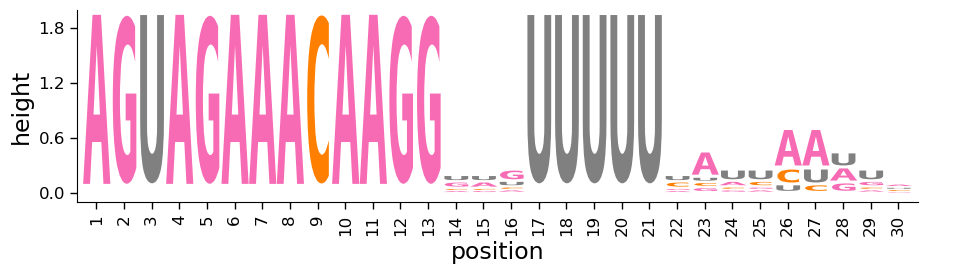

In [58]:
fig, ax = dmslogo.draw_logo(
    data=entropy, x_col="position", letter_col="base", letter_height_col="height",  fixed_ymax=2)
plt.savefig('Figures/vRNA5primeDiv.pdf', format='pdf', bbox_inches = "tight")

In [62]:
cRNA30nt = 'Database/cRNAprom.fa'
if not os.path.isdir('Results'):
    os.mkdir('Results')
if not os.path.isdir('Results/naturalAnalysis'):
    os.mkdir('Results/naturalAnalysis')
mutCalling.fastaReport(inFasta=cRNA30nt, outfile='Results/naturalAnalysis/cRNAprom.tsv')

entropy = pd.read_csv('Results/naturalAnalysis/cRNAprom.tsv', sep='\t')
entropy['A'] = entropy.A/8
entropy['G'] = entropy.G/8
entropy['C'] = entropy.C/8
entropy['U'] = entropy['T']/8
entropy = entropy[['position','A','G','C','U']]

In [63]:
def rowEntropy(row):
    entropy = 2
    for base in ['A','G','C','U']:
        if row[base] != 0:
            entropy += row[base] * np.log2(row[base])
    return entropy

entropy['content'] = entropy.apply(lambda row: rowEntropy(row), axis=1)
for base in ['A','G','C','U']:
    entropy[base] = entropy[base] * entropy['content']

In [64]:
entropy = pd.melt(entropy, id_vars=['position'], value_vars=['A','G','C','U'],
        var_name='base', value_name='height')

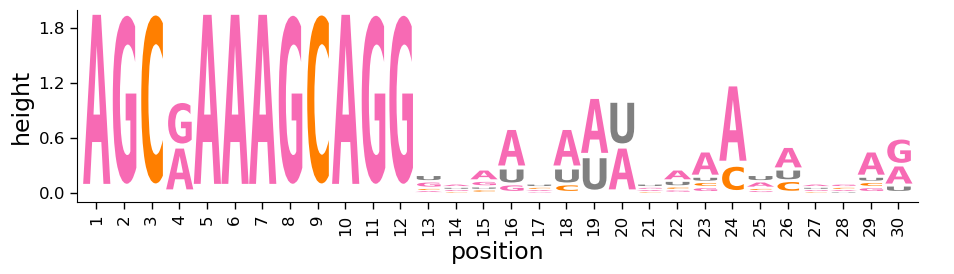

In [65]:
fig, ax = dmslogo.draw_logo(
    data=entropy, x_col="position", letter_col="base", letter_height_col="height",  fixed_ymax=2)
plt.savefig('Figures/cRNA5primeDiv.pdf', format='pdf', bbox_inches = "tight")